importing libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import interpolate

specifying Times New Roman font and to force that within plotting commands

In [2]:
tnr = "Times New Roman"
plt.rcParams['font.sans-serif'] = tnr
plt.rcParams['font.family'] = tnr
params ={'mathtext.default':'regular'}          
plt.rcParams.update(params)

uploading files with data to be plotted

In [3]:
ObsID = 'cycle19'
ObsID_print = 'Cycle 19'
lines = ["SXV", "SiXIV", "SiXIII", "MgXII", "MgXI", "NeX_10.24", "NeIX", "NeX_12.13", "FeXVII_15.01", "FeXVII_16.78"]
wavelengths = [5.039, 6.182, 6.648, 8.421, 9.169, 10.239, 11.544, 12.134, 15.014, 16.780]
opacity_data = np.genfromtxt('kappaZ.txt')[4000:25000]

defining constants and print labels

In [4]:
terminalv = 2.25e6  # in m/s
Rstar = 18.9*6.95e8  # in m
Msun = 1.989e30  # in kg
yr = 3.154e7 # seconds/yr

param_name = r'$\tau_{\star}$'
confidence_range = '68'

functions

In [5]:
def editKappa():
    """returns op_wavelength: all wavelengths in kappaZ.txt in Å, 
    opacity: all kappa values in kappaZ.txt in Å in SI units, 
    and op_10: 10 kappa values for the 10 studied lines in SI units"""
    op_wavelength = 12.408/opacity_data[:, 0]  # input energy data in keV, 12.408 = h*c*(10^{10})/(1.602*10^{-16}), converted to wavelength in Å
    opacity = opacity_data[:, 1]*0.1  # input kappa in cm^2/g, converted to m^2/kg
    op_10 = []
    for i in range(0, len(wavelengths)):
        for j in range(0, len(op_wavelength)-1):
            if np.abs(wavelengths[i]-op_wavelength[j]) < np.abs(wavelengths[i]-op_wavelength[j+1]):
                op_10.append(opacity[j])
                break
    op_10 = np.asarray(op_10)
    return op_wavelength, opacity, op_10
    
def MdotModeling(Mdot, op):
    """takes a Mdot parameter value and a list of opacity values, returns a list of taustar values."""
    model = op*Mdot*(Msun/yr)/(4*np.pi*Rstar*terminalv)
    return model

def tauModeling(tau, lerr, uerr, op):
    """takes a list of tau parameter values with errors and a list of opacity values, returns a list of Mdot values."""
    assert(len(tau) == len(lerr))
    assert(len(tau) == len(uerr))
    assert(len(tau) == len(op))
    Mdot = []
    Mdot_lerr = []
    Mdot_uerr = []
    for i in range(len(tau)):
        Mdot.append((tau[i]*4*np.pi*terminalv*Rstar/op[i])/Msun*yr)
        Mdot_lerr.append((lerr[i]*4*np.pi*terminalv*Rstar/op[i])/Msun*yr)
        Mdot_uerr.append((uerr[i]*4*np.pi*terminalv*Rstar/op[i])/Msun*yr)
    return Mdot, Mdot_lerr, Mdot_uerr

def probInfo():
    """returns data: 10 lines probability distribution in 3d array,
    maxtaus: a list of 10 most probable taustar values for each of the 10 lines."""
    data = []
    maxtaus = []
    for i in lines:
        linedata = np.genfromtxt(i+'_Cstats_tau.txt')
        x = linedata[:, 0]
        y = linedata[:, 1]
        maxtau = x[list(y).index(max(y))]
        data.append(linedata)
        maxtaus.append(maxtau)
    return data, maxtaus

def makeHist(x, y):
    """takes a list of evenly spaced x values and a list of y values and makes two lists for plotting normalized histogram."""
    assert(np.abs((x[1]-x[0])-(x[-1]-x[-2])) <= 1.e-3)
    xbin = np.abs((x[1]-x[0])/2) # notice this is the half bin width
    xvalues = []
    yvalues = []
    sum_under_curve = 0
    for i in range(len(x)):
        xvalues.append(x[i]-xbin)
        xvalues.append(x[i]+xbin)
        yvalues.append(y[i])
        yvalues.append(y[i])
        sum_under_curve += y[i]*xbin*2
    yvalues = yvalues/sum_under_curve    
    return xvalues, yvalues


"""
def findErr(line, a, amax):
    '''takes a 2D array a with specific distribution and perform Monte Carlo simulation, then find 68% confidence region,
    a is the 2d array, where the first column is x, second column is y,
    amax is the point the uncertainty region is evaluated around, which is either max(a_y), or an user defined point.'''
    '''line is a list with name of line and line wavelength, only used to be printed on plots.'''
    x = a[:, 0]
    y = a[:, 1]
    sample_size = int(4.e5)
    err_size = int(sample_size*0.68)
    sample = []
    for i in range(sample_size):
        tf = True
        while tf == True:
            x_sample = np.random.rand(1)[0]*(np.max(x)-np.min(x))+np.min(x)
            P_sample = np.random.rand(1)[0]*np.max(y)
            P_x = np.interp(x_sample, x, y, left=0, right=0)
            if P_sample <= P_x:
                sample.append(x_sample)
                tf = False
    sample = np.array(np.sort(sample))
    lower_sample = []
    upper_sample = []
    for i in sample:
        if i < amax:
            lower_sample.append(i)
        else:
            upper_sample.append(i)
    if len(lower_sample) <= err_size/2:
        lerr = 0
        uerr = sample[err_size]
    else:
        lerr = lower_sample[-int(err_size/2)-1]
        uerr = upper_sample[int(err_size/2)]
    assert(len(upper_sample) > err_size/2) # if assertion fails, probability distribution should be reevaluated using steppar
    
    number_of_included_points = 0
    for i in sample:
        if i > lerr and i < uerr:
            number_of_included_points += 1
    assert(number_of_included_points == err_size)
    
    plt.figure(figsize = (20, 2))
    plt.ylim(bottom = 0, top = 2)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.title("sample points distribution", fontsize = 20)
    plt.plot(sample, np.repeat(1, sample_size), "o", markersize = 0.2, color = "k")
    plt.plot([lerr, uerr], np.repeat(1, 2), "o", markersize = 5, color = "royalblue")
    plt.plot(amax, 1, "o", markersize = 5, color = "lightcoral")
    plt.show
    
    plt.figure(figsize = (5, 4))
    plt.ylim(bottom = -0.05, top = np.max(y)*1.05)
    plt.xlabel("tau", fontsize = 20)
    plt.ylabel("P/tau", fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.plot(x, y, color = "k", linewidth = 1)
    plt.plot([lerr, uerr], np.interp([lerr, uerr], x, y, left=0, right=0), "o", markersize = 5, color = "royalblue")
    plt.plot(amax, np.interp(amax, x, y, left=0, right=0), "o", markersize = 5, color = "lightcoral")
    plt.vlines(amax, ymin = -1, ymax = np.interp(amax, x, y, left=0, right=0), color = 'lightcoral', linestyle = '--', linewidth = 1)
    plt.vlines([lerr, uerr], ymin = -1, ymax = np.interp([lerr, uerr], x, y, left=0, right=0), color = 'royalblue', linestyle = '--', linewidth = 1)
    plt.figtext(0.45, 0.77, r'$\lambda$ = '+str(line[1])+' Å '+(line[0].split("_"))[0], fontsize = 18)
    plt.figtext(0.45, 0.64, r"$\tau_{\star} = %.2f _{-%.2f}^{+%.2f}$" % (amax, amax-lerr, uerr-amax), fontsize = 18)
    plt.show()
    
    return amax-lerr, uerr-amax
"""

def find68fErr(x, y):
    """takes a unnormalized distribution (two lists) and finds the 68% confidence region around the maximum, 
    returns mode, median, and two error bounds."""
    assert(np.abs((x[1]-x[0])-(x[-1]-x[-2])) <= 1.e-3)
    xbin = np.abs((x[1]-x[0])) # notice this is the full bin width
    # normalizing the distribution:
    sum_under_curve = 0
    for i in y:
        sum_under_curve += i*xbin
    y = list(y/sum_under_curve)
    # finding median and compare with mode:
    median_index = 0
    median_prob = xbin*y[median_index]
    while median_prob < 0.5:
        median_index += 1
        median_prob += xbin*y[median_index]
    median = x[median_index]
    mode_index = y.index(max(y))
    mode = x[mode_index]
    if np.around(median, 2) == np.around(mode, 2):
        print('median %.2f exactly the same with mode %.2f.' % (median, mode))
    else:
        print('different values for median %.2f and mode %.2f.' % (median, mode))
        
    # finding local minimums and maximums:
    list_trend = ['start']    
    for i in range(len(y)-1):
        if y[i+1] <= y[i]:
            list_trend.append('decrease')
        else:
            list_trend.append('increase')
    local_max_x = [] # x coordinates of local maximums
    local_max_y = [] # y coordinates of local maximums
    local_min_x = [] # x coodinates of local minimums
    local_min_y = [] # y coodinates of local minimums
    for i in range(1, len(y)-2):
        if list_trend[i+1] != list_trend[i]:
            if list_trend[i] == 'increase':
                local_max_x.append(x[i])
                local_max_y.append(y[i])
            elif list_trend[i] == 'decrease':
                local_min_x.append(x[i])
                local_min_y.append(y[i])
                
    # finding error bounds:
    min_max_x = np.sort(local_max_x + local_min_x + list([x[0], x[-1]])) # sorted array of list of x coordinates of mins, maxes, and two ends of x
    mode_pos = list(min_max_x).index(x[mode_index])
    err_region = 0
    pos_1 = 1
    pos_2 = 1
    #while np.around(err_region, 2) != 0.68:
    while np.abs(err_region - 0.68) > 0.015:
        index_2_start = list(x).index(min_max_x[mode_pos+pos_2-1])
        index_2_end = list(x).index(min_max_x[mode_pos+pos_2])
        if len(min_max_x) == 2:
            index_1_start = 0
            index_1_end = 1
        else:
            index_1_start = list(x).index(min_max_x[mode_pos-pos_1])
            index_1_end = list(x).index(min_max_x[mode_pos-pos_1+1])
        x_considered = x[index_1_start:index_2_end]
        y_considered = y[index_1_start:index_2_end]
        f_reversed_1 = interpolate.interp1d(y[index_1_start:index_1_end+1], x[index_1_start:index_1_end+1])
        f_reversed_2 = interpolate.interp1d(y[index_2_start:index_2_end+1], x[index_2_start:index_2_end+1])
        err_prob = np.min([np.max(y[index_1_start:index_1_end+1]), np.max(y[index_2_start:index_2_end+1])])
        while err_region < 0.68:
            err_region = 0
            err_prob = err_prob - (np.max(y)-np.min(y))*1.e-4
            if err_prob <= np.min(y[index_1_start:index_1_end+1]):
                pos_1 += 1
                if mode_pos-pos_1 < 0:
                    bound_1 = np.min(x)
                    bound_2 = f_reversed_2(err_prob)
                else:
                    break
            if err_prob <= np.min(y[index_2_start:index_2_end+1]):
                pos_2 += 1
                if mode_pos+pos_2 > len(min_max_x)-1:
                    bound_2 = np.max(x)
                    bound_1 = f_reversed_1(err_prob)
                else:
                    break
            if (err_prob > np.min(y[index_2_start:index_2_end+1])) and (err_prob > np.min(y[index_1_start:index_1_end+1])):
                bound_1 = f_reversed_1(err_prob)
                bound_2 = f_reversed_2(err_prob)
            for i in range(len(x_considered)):
                if (x_considered[i]-xbin/2 >= bound_1) and (x_considered[i]+xbin/2 <= bound_2):
                    err_region += y_considered[i]*xbin
                elif (x_considered[i] < x[mode_index]) and (x_considered[i]+xbin/2 > bound_1):
                    err_region += ((x_considered[i] + xbin/2) - bound_1)*y_considered[i]
                elif (x_considered[i] > x[mode_index]) and (x_considered[i]-xbin/2 < bound_2):
                    err_region += (bound_2 - (x_considered[i] - xbin/2))*y_considered[i]
            #print(err_region, bound_1, bound_2)
    
    lerr = bound_1
    uerr = bound_2
    sum_68 = 0
    for i in range(len(x)):
        if x[i] < uerr and x[i] > lerr:
            sum_68 += y[i]*xbin
    print('lerr: %.2f, uerr %.2f' % (lerr, uerr))
    print('calculated error region: %.2f, estimated error region %.2f' % (err_region, sum_68))
    
    #xvalues, yvalues = makeHist(x, y)
    #plt.xlim(left = -0.1, right = np.max(x)*1.05)
    #plt.plot(xvalues, yvalues, markersize = '1', color = 'k')
    #plt.plot(median, y[median_index], 'o')
    #plt.plot(mode, y[mode_index], 'o')
    #plt.vlines([lerr, uerr], ymin = -0.01, ymax = np.max(y)*1.05, linestyle = '--', linewidth = 1)
    #plt.hlines(err_prob, xmin = -0.1, xmax = np.max(x)*1.05, linestyle = '--', linewidth = 1)
    #plt.show()
    
    xvalues, yvalues = makeHist(x, y)
    plt.figure(figsize = (5, 4))
    plt.xlabel('$x$', fontsize = 27.5*0.5)
    plt.ylabel(r'$P_x$', fontsize = 27.5*0.5)
    plt.xlim(left = -0.1, right = np.max(x)*1.05)
    plt.ylim(bottom = 0, top = max(yvalues)*1.05)
    plt.locator_params(nbins = 6)
    plt.xticks(fontsize = 25*0.5)
    plt.yticks(fontsize = 25*0.5)
    plt.plot(median, y[median_index], 'o', color = 'green')
    plt.plot(mode, y[mode_index], 'o', color = 'red')
    plt.vlines([lerr, uerr], ymin = -0.01, ymax = np.max(y)*1.05, linestyle = '--', linewidth = 1)
    plt.hlines(err_prob, xmin = -0.1, xmax = np.max(x)*1.05, linestyle = '--', linewidth = 1)
    plt.plot(xvalues, yvalues, markersize = '1', color = 'k')
    #plt.yscale('log')
    plt.vlines([lerr, uerr], ymin = -0.01, ymax = np.max(y)*1.05, linestyle = '--', linewidth = 1)
    plt.show()
    
    return mode, median, lerr, uerr

def printX(bestfit, lerr, uerr):
    """returns a string of printed Mdot on the plot in preferred format."""
    i = 0
    while True:
        if bestfit/(10**i) <= 10 and bestfit/(10**i) >= 1:
            break
        else:
            if bestfit/(10**i) > 10:
                i += 1
            if bestfit/(10**i) < 1:
                i -= 1
    if i <= 2 and i >= -2:
        return r'$\dot{M}_{%d}$ = $%.2f_{-%.2f}^{+%.2f}$' % (i, bestfit, lerr, uerr)
    else:
        return r'$\dot{M}_{%d}$ = $%.2f_{-%.2f}^{+%.2f}$' % (i, bestfit*(10**-i), lerr*(10**-i), uerr*(10**-i))

finding unertainty regions for each of the 10 lines

requires very long time to run, usually running once is enough

line: SXV
different values for median 0.16 and mode 0.13.
lerr: 0.05, uerr 0.24
calculated error region: 0.68, estimated error region 0.67


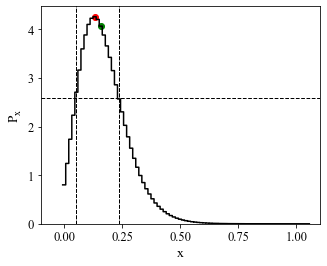


line: SiXIV
different values for median 0.62 and mode 0.57.
lerr: 0.41, uerr 0.77
calculated error region: 0.68, estimated error region 0.67


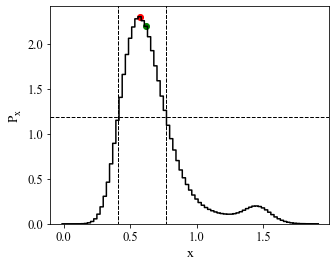


line: SiXIII
median 0.66 exactly the same with mode 0.66.
lerr: 0.61, uerr 0.72
calculated error region: 0.68, estimated error region 0.68


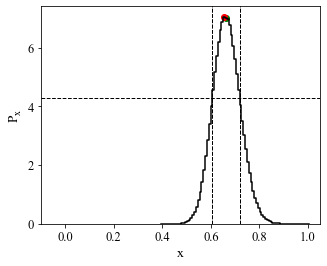


line: MgXII
different values for median 1.03 and mode 1.01.
lerr: 0.91, uerr 1.14
calculated error region: 0.68, estimated error region 0.70


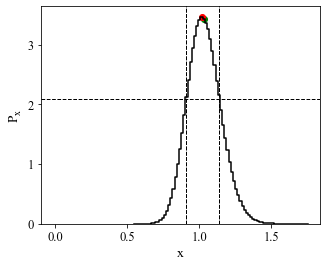


line: MgXI
different values for median 0.81 and mode 0.80.
lerr: 0.74, uerr 0.88
calculated error region: 0.68, estimated error region 0.71


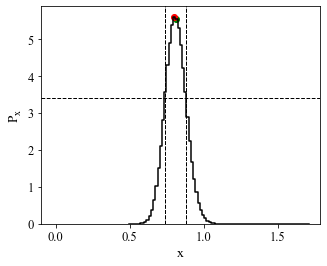


line: NeX_10.24
different values for median 2.50 and mode 2.53.
lerr: 2.26, uerr 2.75
calculated error region: 0.68, estimated error region 0.68


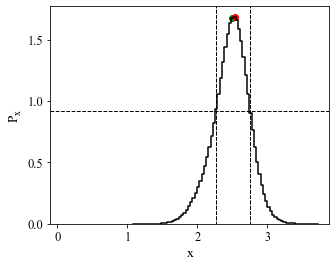


line: NeIX
different values for median 1.70 and mode 1.58.
lerr: 1.26, uerr 2.01
calculated error region: 0.68, estimated error region 0.68


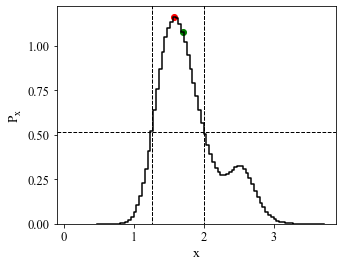


line: NeX_12.13
median 3.07 exactly the same with mode 3.07.
lerr: 2.92, uerr 3.23
calculated error region: 0.68, estimated error region 0.66


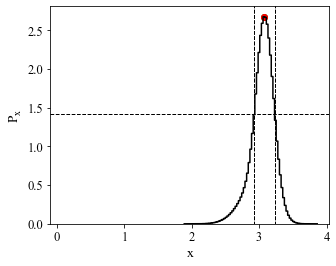


line: FeXVII_15.01
different values for median 2.77 and mode 3.18.
lerr: 2.32, uerr 3.29
calculated error region: 0.68, estimated error region 0.67


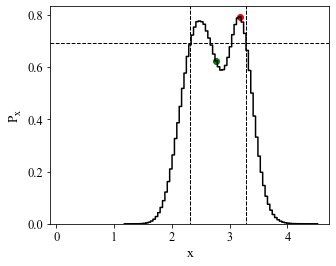


line: FeXVII_16.78
different values for median 4.12 and mode 4.01.
lerr: 3.34, uerr 4.71
calculated error region: 0.68, estimated error region 0.68


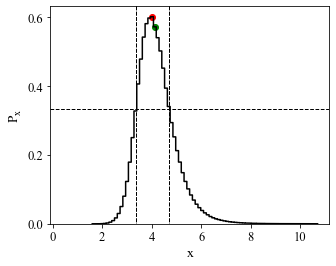

In [6]:
"""
data, maxtaus = probInfo()

lerr = []
uerr = []
for i in range(len(data)):
    line = [lines[i], wavelengths[i]]
    line_lerr, line_uerr = findErr(line, data[i], maxtaus[i])
    lerr.append(line_lerr)
    uerr.append(line_uerr)
"""
data, maxtaus = probInfo()

lerr = []
uerr = []
mode = []
median = []
for i in range(0, len(data)):
    print("line: %s" % lines[i])
    line_mode, line_median, line_lerr, line_uerr = find68Err(data[i][:, 0], data[i][:, 1])
    lerr.append(line_lerr)
    uerr.append(line_uerr)
    mode.append(line_mode)
    median.append(line_median)
    print()

writing the lower and upper lerror of all lines into a txt file

returning a message if a change is made to the previous file, in which case the findErr fnuction isn't universal and needs modification.

In [7]:
def writeErr(maxes, lerr, uerr):
    """writes a txt file with wavelength in the first column, 
    taustar in the second, 
    lerr in the third, and 
    uerr in the fourth."""
    txt = 'massloss_errors.txt'
    data = np.genfromtxt(txt)
    outputtxt = open(txt, 'w')
    for i in range(0, len(data)):
        linemax = np.around(maxes[i], 2)
        linelerr = np.around(maxes[i] - lerr[i], 2)
        lineuerr = np.around(uerr[i] - maxes[i], 2)
        if linelerr != data[i][2] or lineuerr != data[i][3]:
            print("new uncertainty region is found in %f Å" % data[i][0])
            if linelerr != data[i][2]:
                print("lower error is changed from %f to %f" % (data[i][2], linelerr))
            if lineuerr != data[i][3]:
                print("upper error is changed from %f to %f" % (data[i][3], lineuerr))
        outputtxt.write(str(data[i][0])+' '+str(linemax)+' '+str(linelerr)+' '+str(lineuerr)+'\n')
    return

#writeErr(maxtaus, lerr, uerr)

finding the best-fit Mdot model by maxtau probability distribution (used)

median 0.00 exactly the same with mode 0.00.
lerr: 0.00, uerr 0.00
calculated error region: 0.68, estimated error region 0.68


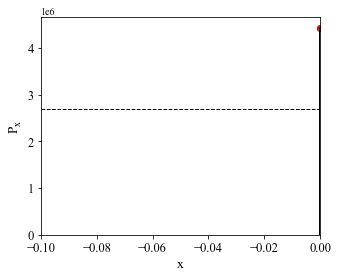

In [8]:
def findProb(model, data):
    """model is a list of 10 taustars on a specific Mdot value"""
    """find the probability of the Mdot model for each of the 10 lines, and return the total probability"""
    assert(len(model) == len(data))
    likelihood = 1
    for i in range(len(model)):
        x = list(data[i][:, 0])
        y = list(data[i][:, 1])
        if model[i] <= x[0]:
            modeltauprob = y[0]
        elif model[i] >= x[-1]:
            modeltauprob = y[-1]
        else:
            f = interpolate.interp1d(x, y)
            modeltauprob = f(model[i])
        likelihood = likelihood*modeltauprob
    return likelihood

def findBestFit(op_10, maxtaus, data):
    """takes op_10 for modeling each Mdot into tau vs wavelength, finds the best fit,
    returns unnormalized Mdot probability distribution and the best fit."""
    n = 10000
    fit_predictedmax = 3.00*(10**(-6))
    fit_predictedmin = 1.25*(10**(-6))
    a = np.linspace(fit_predictedmin, fit_predictedmax, n)
    likelihood_list = []
    for i in a:
        fitmodel_10 = MdotModeling(i, op_10)
        likelihood = findProb(fitmodel_10, data)
        likelihood_list.append(likelihood)
    bestfit = a[likelihood_list.index(max(likelihood_list))]
    return a, likelihood_list, bestfit

op_wavelength, opacity, op_10 = editKappa()
Mdot_vals, likelihood_vals, bestfit = findBestFit(op_10, maxtaus, data) # likelihood_vals not yet normalized.
bestfit, bestfit_median, bestfit_lerr, bestfit_uerr = find68Err(Mdot_vals, likelihood_vals)
Mdotmodel = MdotModeling(bestfit, opacity)
Mdotmodel_10 = MdotModeling(bestfit, op_10)
Mdotmodel_lerr = MdotModeling(bestfit_lerr, opacity)
Mdotmodel_uerr = MdotModeling(bestfit_uerr, opacity)
model_print = printX(bestfit, bestfit-bestfit_lerr, bestfit_uerr-bestfit)
Mdot_histvals, likelihood_histvals = makeHist(Mdot_vals, likelihood_vals)

In [9]:
def writeProb(x, y):
    txt = open('%s_mass_loss_pdf.txt' % ObsID, 'w')
    for i in range(len(x)):
        txt.write(str(x[i])+' '+str(y[i])+'\n')

writeProb(Mdot_vals, likelihood_vals)

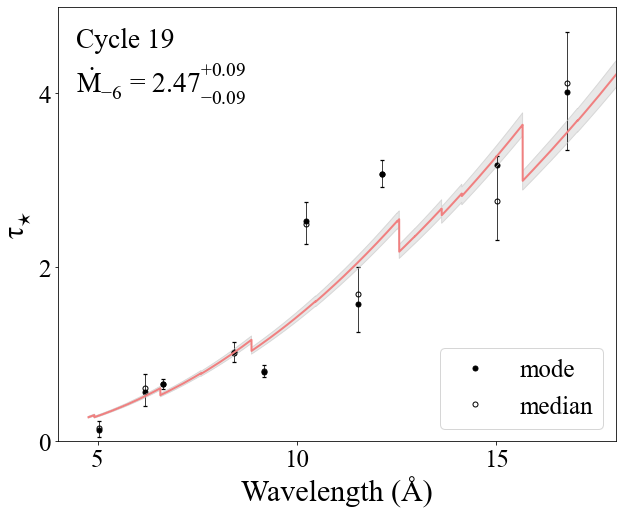

In [10]:
# plotting
plt.figure(figsize = (10, 8))
plt.xlabel('Wavelength (Å)', fontsize = 30)
plt.ylabel(param_name, fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.locator_params(nbins = 4)
plt.ylim(bottom = 0, top = 5)
plt.xlim(left = 4, right = 18)
plt.plot(wavelengths, mode, "o", color = 'black', markersize = 5, label = 'mode')
plt.plot(wavelengths, median, "o", color = 'black', markersize = 5, mfc = 'none', label = 'median')
plt.errorbar(wavelengths, mode, yerr = [np.array(mode)-np.array(lerr), np.array(uerr)-np.array(mode)], ls = 'none', color = 'black', linewidth = 0.75, capsize = 2., capthick = 1.25)
plt.plot(op_wavelength, Mdotmodel_lerr, color = 'lightgrey', linestyle = '-', linewidth = 0.5)
plt.plot(op_wavelength, Mdotmodel_uerr, color = 'lightgrey', linestyle = '-', linewidth = 0.5)
plt.fill_between(op_wavelength, Mdotmodel_lerr, Mdotmodel_uerr, color = 'lightgrey', alpha = 0.5)
plt.plot(op_wavelength, Mdotmodel, color = 'lightcoral', linestyle = '-', linewidth = 2)
plt.figtext(0.15, 0.81, '%s' % str(ObsID_print), fontsize = 27.5)
plt.figtext(0.15, 0.73, model_print, fontsize = 27.5)
plt.legend(loc = "lower right", fontsize = 25)
#plt.savefig('taustar_vs_wavelength.png', bbox_inches = 'tight')
plt.show()

In [11]:
if ObsID == 'cycle19':
    mlpd = np.genfromtxt('cycle1_mass_loss_pdf.txt')
elif ObsID == 'cycle1':
    mlpd = np.genfromtxt('cycle19_mass_loss_pdf.txt')
mlpd_x = mlpd[:, 0]
mlpd_y = mlpd[:, 1]
mlpd_hist_x, mlpd_hist_y = makeHist(mlpd_x, mlpd_y)
    
# plotting    
fig = plt.figure(figsize = (10, 8))
plt.xlabel('Wavelength (Å)', fontsize = 30)
plt.ylabel(param_name, fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.locator_params(nbins = 4)
plt.ylim(bottom = 0, top = 6)
plt.xlim(left = 4, right = 18)

plt.plot(op_wavelength, Mdotmodel, color = 'lightcoral', linestyle = '-', linewidth = 2)
plt.plot(op_wavelength, Mdotmodel_lerr, color = 'lightgrey', linestyle = '-', linewidth = 0.5)
plt.plot(op_wavelength, Mdotmodel_uerr, color = 'lightgrey', linestyle = '-', linewidth = 0.5)
plt.fill_between(op_wavelength, Mdotmodel_lerr, Mdotmodel_uerr, color = 'lightgrey', alpha = 0.5)
plt.plot(op_wavelength, Mdotmodel, color = 'lightcoral', linestyle = '-', linewidth = 2)

for i in range(len(data)):
    sigma_n = 5
    sigma_l = np.array(mode)[i]-np.array(lerr)[i]
    sigma_u = np.array(uerr)[i]-np.array(mode)[i]
    all_y = data[i][:, 0]
    all_x = data[i][:, 1]
    y_plotted = []
    x_plotted = []
    for j in range(len(all_y)):
        if all_y[j] >= mode[i] - sigma_n*sigma_l and all_y[j] <= mode[i] + sigma_n*sigma_u:
            y_plotted.append(all_y[j])
            x_plotted.append(all_x[j])
    x_plotted = wavelengths[i] - (x_plotted/np.max(x_plotted))/2
    plt.fill_betweenx(y_plotted, x_plotted, np.repeat(wavelengths[i], len(x_plotted)), color = "cornflowerblue", alpha = 0.3, label = 'probability distribution')
plt.figtext(0.15, 0.81, '%s' % str(ObsID_print), fontsize = 27.5)
plt.figtext(0.15, 0.73, model_print, fontsize = 27.5)

ax1 = fig.add_axes([0.19, 0.59, 0.27, 0.27])
ax1.set_xlabel(r'$\dot{M}_{-6}$', fontsize = 16)
ax1.set_ylabel(r'$P_{\dot{M}}$', fontsize = 16)
ax1.set_ylim(bottom = min(likelihood_histvals)*0.95/1.e6, top = max(list(likelihood_histvals)+list(mlpd_hist_y))*1.05/1.e6)
ax1.locator_params(nbins = 6)
ax1.tick_params(labelsize = 14)

ax1.plot(np.array(mlpd_hist_x)*1e6, np.array(mlpd_hist_y)/1e6, color = 'grey', linestyle = '-', linewidth = 1, alpha = 0.6)
ax1.plot(np.array(Mdot_histvals)*1.e6, likelihood_histvals/1.e6, color = 'black', linestyle = '-', linewidth = 1)
ax1.vlines([bestfit_lerr*1.e6, bestfit_uerr*1.e6], ymin = 0, ymax = 6, color = 'grey', linestyle = '--', linewidth = 1)

#plt.savefig('taustar_vs_wavelength_pd.png', bbox_inches = 'tight')
plt.show()

OSError: cycle1_mass_loss_pdf.txt not found.

In [ ]:
plt.figure(figsize = (10, 8))
plt.xlabel(r'$\dot{M}$ (E-6)', fontsize = 27.5)
plt.ylabel(r'$P_{\dot{M}}$', fontsize = 27.5)
plt.ylim(bottom = min(likelihood_histvals)*0.95, top = max(likelihood_histvals)*1.05)
plt.locator_params(nbins = 9)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.plot(np.array(Mdot_histvals)*1.e6, likelihood_histvals, color = 'black')
#plt.yscale('log')
plt.vlines([bestfit_lerr*1.e6, bestfit_uerr*1.e6], ymin = 0, ymax = 5e6, color = 'grey', linestyle = '--', linewidth = 1.75)
plt.figtext(0.15,0.83, 'ObsID: %s' % str(ObsID), fontsize = 23)
plt.figtext(0.15,0.75, r'max '+model_print, fontsize = 23)
#plt.savefig('massloss_prob.png', bbox_inches = 'tight')
plt.show()